**ISOM 672 Final Project - Ad Click Prediction**

#1 Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer, recall_score
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score 
from sklearn import neighbors, datasets
from sklearn.model_selection import learning_curve 
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.metrics import roc_curve,accuracy_score,recall_score
from sklearn.metrics import auc
from sklearn.model_selection import validation_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 2 Join the Attributes

In [2]:
data1 = pd.read_csv('email_table.csv')
data2 = pd.read_csv('email_opened_table.csv')
data3 = pd.read_csv('link_clicked_table.csv')
data1.columns

Index(['email_id', 'email_text', 'email_version', 'hour', 'weekday',
       'user_country', 'user_past_purchases'],
      dtype='object')

In [3]:
open_list = data2.iloc[:,0].tolist()
click_list = data3.iloc[:,0].tolist()

In [4]:
def f(row):
    if row['email_id'] in open_list:
        val = 1
    else:
        val = 0
    return val

data1['if_opened'] = data1.apply(f, axis=1)

In [5]:
def f(row):
    if row['email_id'] in click_list:
        val = 1
    else:
        val = 0
    return val

data1['if_clicked'] = data1.apply(f, axis=1)

#3 Explore the dataset

##3.1 Statistics

In [6]:
data1.describe()

,email_id,hour,user_past_purchases,if_opened,if_clicked
count,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000
mean,498690.196160,9.059300,3.87845,0.103450,0.021190
std,289230.727534,4.439637,3.19611,0.304547,0.144018
min,8.000000,1.000000,0.00000,0.000000,0.000000
25%,246708.250000,6.000000,1.00000,0.000000,0.000000
50%,498447.000000,9.000000,3.00000,0.000000,0.000000
75%,749942.750000,12.000000,6.00000,0.000000,0.000000
max,999998.000000,24.000000,22.00000,1.000000,1.000000


##3.2 Correlation Matrix

In [7]:
#transform text into number
data1['email_text'] = np.where(data1['email_text'] == 'long_email', 1,0)

data1['email_version'] = np.where(data1['email_version'] == 'personalized', 1,0)

data1['weekday'] = np.where(data1['weekday'] == 'Monday', 1, data1['weekday'])
data1['weekday'] = np.where(data1['weekday'] == 'Tuesday', 2, data1['weekday'])
data1['weekday'] = np.where(data1['weekday'] == 'Wednesday', 3, data1['weekday'])
data1['weekday'] = np.where(data1['weekday'] == 'Thursday', 4, data1['weekday'])
data1['weekday'] = np.where(data1['weekday'] == 'Friday', 5, data1['weekday'])
data1['weekday'] = np.where(data1['weekday'] == 'Saturday', 6, data1['weekday'])
data1['weekday'] = np.where(data1['weekday'] == 'Sunday', 7, data1['weekday'])

data1['user_country'] = np.where(data1['user_country'] == 'US', 1, data1['user_country'])
data1['user_country'] = np.where(data1['user_country'] == 'UK', 2, data1['user_country'])
data1['user_country'] = np.where(data1['user_country'] == 'FR', 3, data1['user_country'])
data1['user_country'] = np.where(data1['user_country'] == 'ES', 4, data1['user_country'])

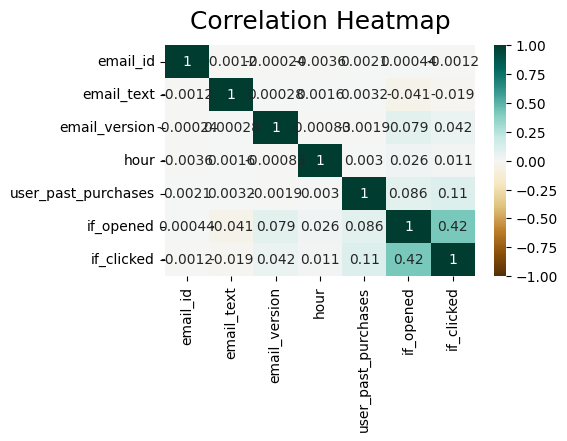

In [8]:
#Correlation Matrix
plt.figure(figsize=(5, 3))
heatmap = sns.heatmap(data1.corr(), vmin=-1, vmax=1, cmap='BrBG',annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
plt.show()

##3.3 Attribute Distribution

C:\Users\jacks\AppData\Local\Temp\ipykernel_16168\1299295373.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  fig_1= set1.hist(ax = ax,layout=(8,4),xlabelsize=30,ylabelsize=30,bins=100)


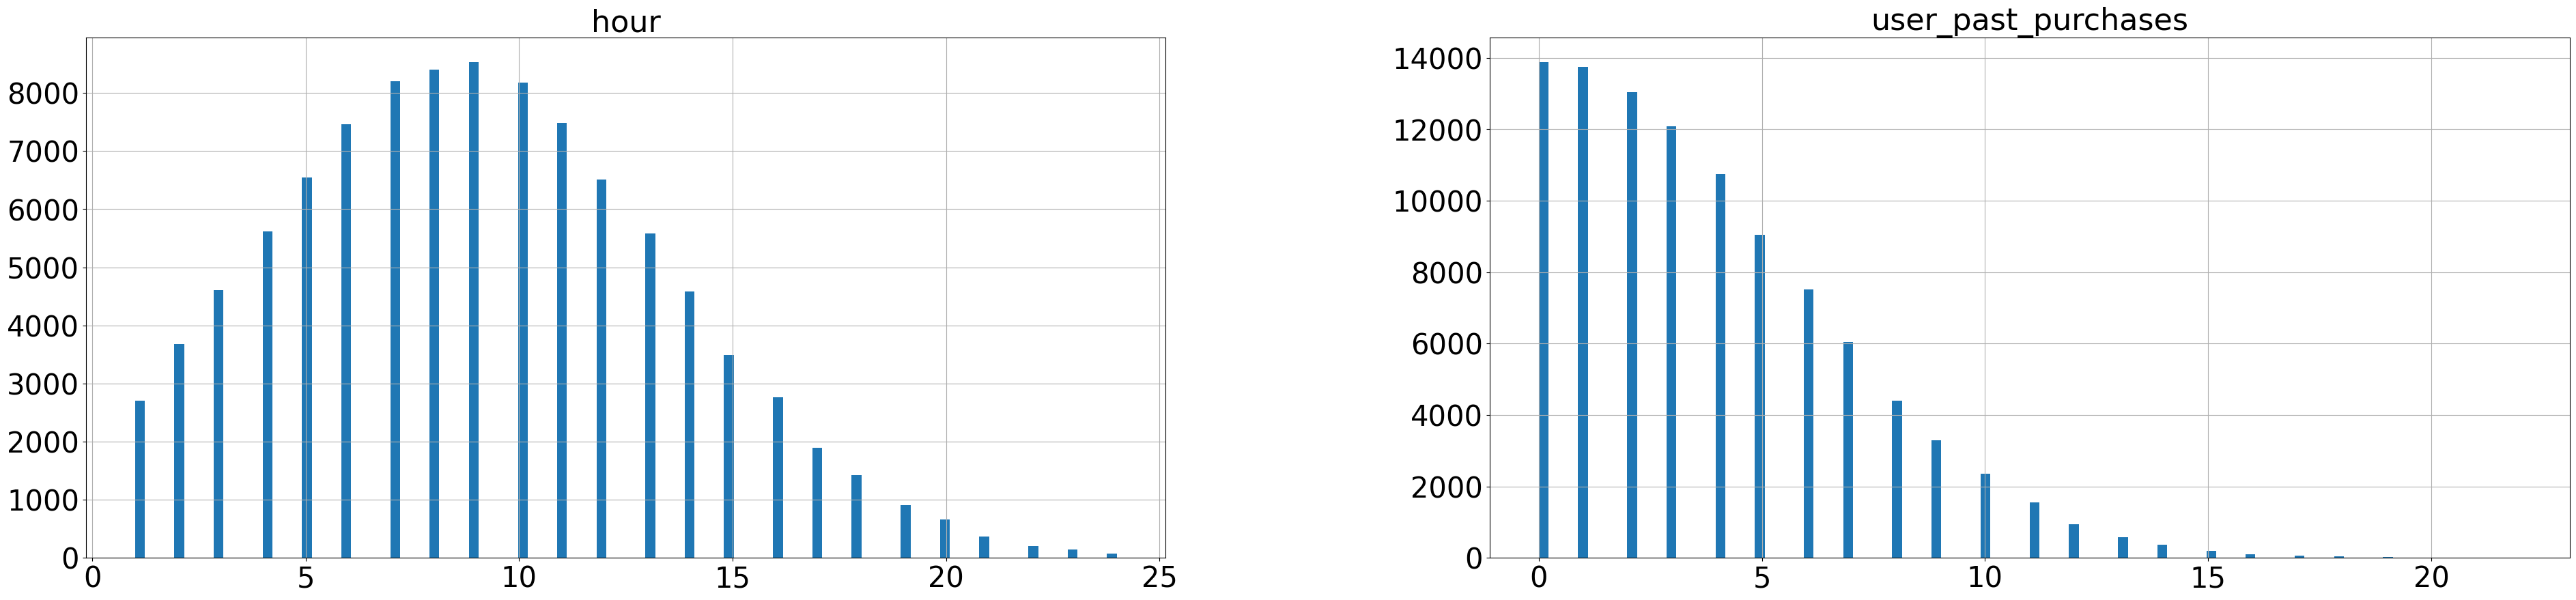

In [9]:
#Distribution of numeric attributes and 'hour'
set1 = data1[['hour','user_past_purchases']]

fig = plt.figure(figsize = (100,100))
ax = fig.gca()
fig_1= set1.hist(ax = ax,layout=(8,4),xlabelsize=30,ylabelsize=30,bins=100)
[x.title.set_size(32) for x in fig_1.ravel()]
plt.show()


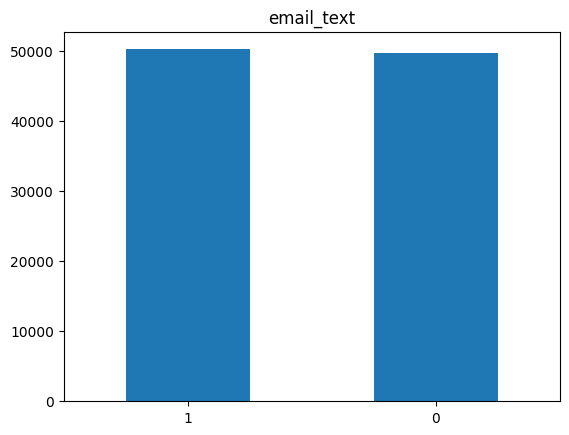

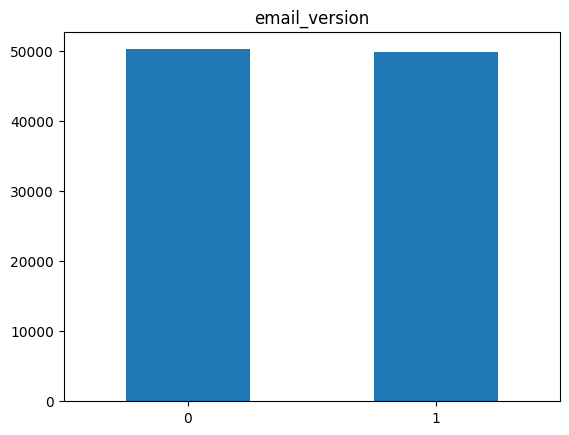

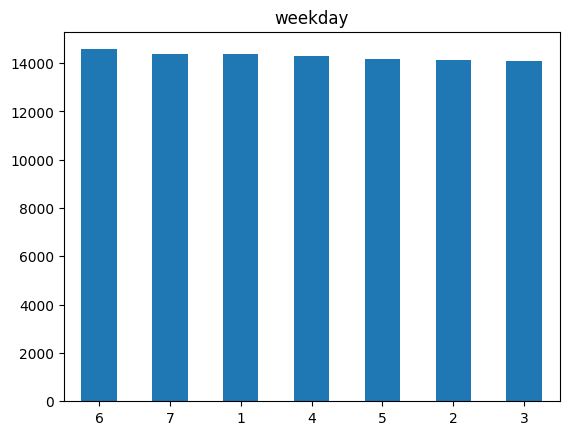

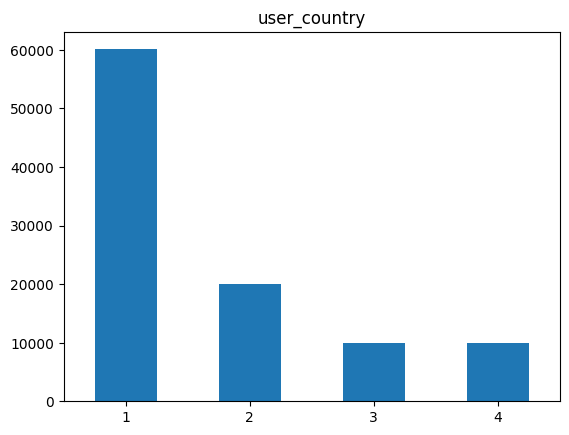

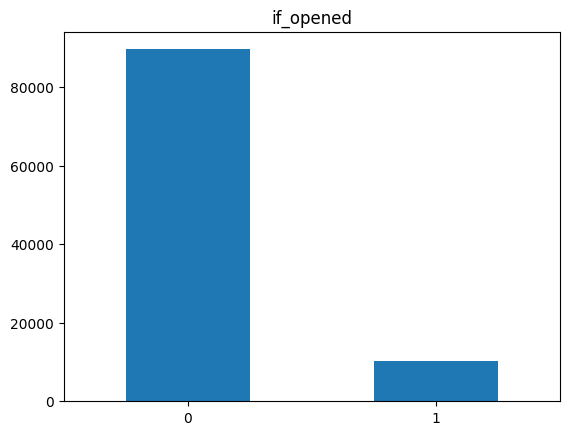

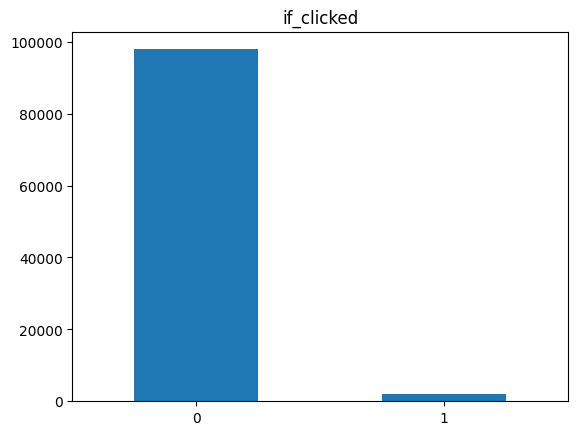

In [10]:
#Distribution of categorical attributes except 'hour'
set2 = data1[['email_text','email_version','weekday','user_country','if_opened','if_clicked']] 
for i in range(6):
  set2.iloc[:,i].value_counts().plot(kind='bar')
  plt.title(set2.columns[i])
  plt.xticks(rotation=0)
  plt.show()

In [11]:
data1.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,if_opened,if_clicked
0,85120,0,1,2,7,1,5,0,0
1,966622,1,1,12,7,2,2,1,1
2,777221,1,1,11,3,1,2,0,0
3,493711,0,0,6,1,2,1,0,0
4,106887,1,0,14,1,1,6,0,0


#4 Data preparation

##4.1 Missing Data

In [12]:
data1.isnull().sum()

email_id               0
email_text             0
email_version          0
hour                   0
weekday                0
user_country           0
user_past_purchases    0
if_opened              0
if_clicked             0
dtype: int64

##4.2 Duplicate Data

In [13]:
data1.duplicated().sum()

0

##4.3 Transformation

Index(['email_id', 'email_text', 'email_version', 'hour', 'weekday',
       'user_country', 'if_opened', 'if_clicked', 'user_past_purchases_log'],
      dtype='object')

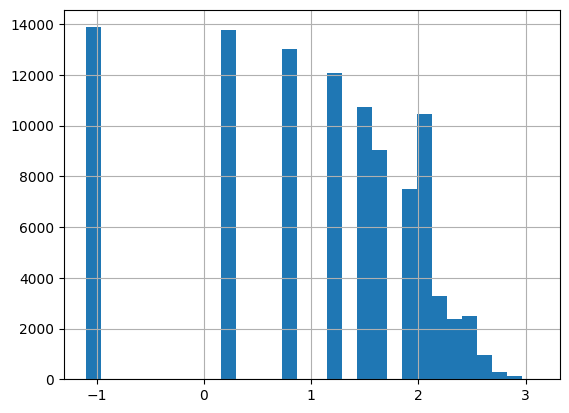

In [14]:
data1['user_past_purchases_log'] = np.log(data1['user_past_purchases']+(1/3))
data1['user_past_purchases_log'].hist(bins=30)
data_trans = data1.drop(['user_past_purchases'], axis = 1)
data_trans.columns

##4.4 Feature Engineering

In [15]:
data_trans_eng = data_trans
data_trans_eng['user_past_purchases_log_square'] = pow(data_trans_eng['user_past_purchases_log'],2)

##4.5 Deal With Nominal Attributes

In [16]:
data_trans_dummy = pd.get_dummies(data=data_trans_eng,columns=['user_country'])

#delete one dummy column
data_trans_dummy = data_trans_dummy.drop(['user_country_1'], axis = 1)
data_trans_dummy.head()

c:\Users\jacks\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


,email_id,email_text,email_version,hour,weekday,if_opened,if_clicked,user_past_purchases_log,user_past_purchases_log_square,user_country_2,user_country_3,user_country_4
0,85120,0,1,2,7,0,0,1.673976,2.802197,0,0,0
1,966622,1,1,12,7,1,1,0.847298,0.717914,1,0,0
2,777221,1,1,11,3,0,0,0.847298,0.717914,0,0,0
3,493711,0,0,6,1,0,0,0.287682,0.082761,1,0,0
4,106887,1,0,14,1,0,0,1.845827,3.407076,0,0,0


##4.6 Split Data into Train&Test set

In [17]:
X = data_trans_dummy.iloc[:, np.r_[1:6,7:12]]
y = data_trans_dummy['if_clicked']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)
X_train.head()

,email_text,email_version,hour,weekday,if_opened,user_past_purchases_log,user_past_purchases_log_square,user_country_2,user_country_3,user_country_4
75220,1,1,6,1,0,-1.098612,1.206949,0,0,1
48955,0,1,9,1,0,2.233592,4.988934,0,0,0
44966,0,0,11,5,0,0.287682,0.082761,0,0,0
13568,1,0,11,3,0,1.203973,1.449551,0,0,0
92727,1,1,5,7,0,1.673976,2.802197,1,0,0


##4.7 Dataset Balancing

In [18]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

print('Original dataset shape %s' % Counter(y))

ros = RandomOverSampler(random_state=42, 
                        sampling_strategy=0.7) # default sampling strategy: resample all classes but the majority class
                                               # the float number corresponds to the desired ratio of the number of samples 
                                               # in the minority class over the number of samples in the majority class after resampling.
X_oversampled_train, y_oversampled_train = ros.fit_resample(X_train, y_train)

print('Resampled training set shape %s' % Counter(y_oversampled_train))

Original dataset shape Counter({0: 97881, 1: 2119})
Resampled training set shape Counter({0: 78334, 1: 54833})


##4.8 Feature Selection

In [19]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

###4.8.1 kNN

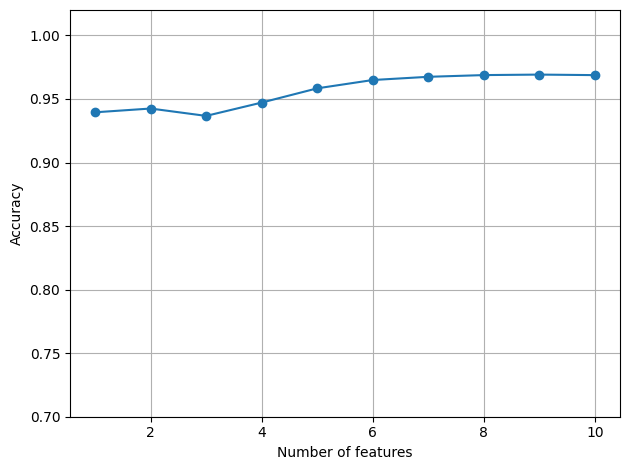

In [20]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_oversampled_train_std = stdsc.fit_transform(X_oversampled_train)
X_test_std = stdsc.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X_oversampled_train_std, y_oversampled_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('feature_selection.png', dpi=300)
plt.show()

##4.9 Learning Curve

In [21]:
#learning curve for logistic regression
def plot_learning_curve(estimator,        # data science algorithm
                        title,            # title of the plot
                        X_train, y_train,             # data (features and target variable)
                        ylim=None,        # minimum and maximum y values plotted
                        cv=None,          # cross validation splits
                        n_jobs=1,         # parallell estimation using multiple processors
                        train_sizes=np.linspace(.1, 1.0, 10)): #linspace returns evenly spaced numbers over a specified interval (start, stop, num)
        plt.figure()                    # display figure
        plt.title(title)                # specify title based on parameter provided as input
        if ylim is not None:            # if ylim was specified as an input, make sure the plots use these limits
            plt.ylim(*ylim)
        plt.xlabel("Training examples") # y label title
        plt.ylabel("Score")
        
        train_sizes, train_scores, test_scores = learning_curve(estimator, # data science algorithm
                                                            X_oversampled_train, y_oversampled_train,      # data (features and target variable)  
                                                            cv=cv,     # cross-validation folds
                                                            n_jobs=n_jobs, # number of jobs to run in parallel using multiple processors
                                                            train_sizes=train_sizes) 
        
        train_scores_mean = np.mean(train_scores, axis=1) # compute the arithmetic mean along the specified axis.
        train_scores_std = np.std(train_scores, axis=1)   # compute the standard deviation along the specified axis.
        test_scores_mean = np.mean(test_scores, axis=1)   # compute the arithmetic mean along the specified axis.
        test_scores_std = np.std(test_scores, axis=1)     # compute the standard deviation along the specified axis.

        plt.grid()
        
        plt.fill_between(train_sizes,                            # the x coordinates of the nodes defining the curves
                     train_scores_mean - train_scores_std,   # the y coordinates of the nodes defining the first curve
                     train_scores_mean + train_scores_std,   # the y coordinates of the nodes defining the second curve
                     alpha=0.1,                              # level of transparency in the color fill
                     color="r")                              # train data performance indicated with red
        plt.fill_between(train_sizes, 
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, 
                     alpha=0.1,
                     color="g")  
        
        # Cross-validation means indicated by dots
        # Train data performance indicated with red
        plt.plot(train_sizes,                                    # the horizontal coordinates of the data points 
                 train_scores_mean,                              # the vertical coordinates of the data points
                 'o-',                                           # o- will produce a small circle and a solid line to connect the markers
                 color="r",                                      # line of red color
                 label="Training score") 
        
        # Test data performance indicated with green
        plt.plot(train_sizes, 
                 test_scores_mean, 
                 'o-', 
                 color="g",                                      # line of green color
                 label="Cross-validation score")
        
        plt.legend(loc="best")                      # show legend of the plot at the best location possible
        return plt

###4.9.1 Decision Tree

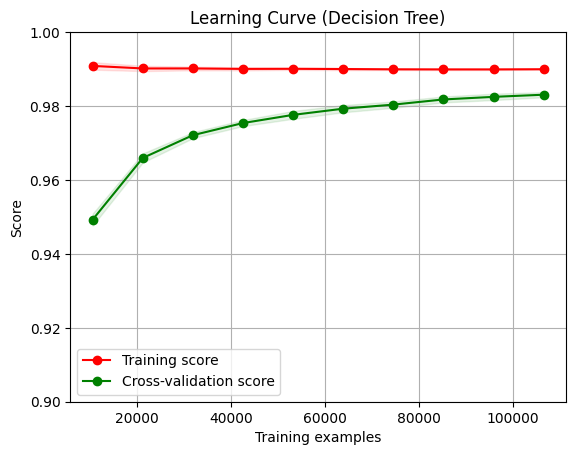

In [23]:
title = "Learning Curve (Decision Tree)"
cv = ShuffleSplit(n_splits=10,          # number of re-shuffling & splitting iterations
                  test_size=0.2,        # represents the proportion of the dataset to include in the test split (float between 0.0 and 1.0) 
                  random_state=42)      # the seed used by the random number generator
estimator = DecisionTreeClassifier()

plot_learning_curve(estimator,      # data science algorithm
                    title,          # title of the plot
                    X_oversampled_train, y_oversampled_train,           # data (features and target variable)
                    (0.9, 1),    # minimum and maximum y values plotted
                    cv=cv,          # cross-validation folds (produced above)
                    n_jobs=4)       # parallell estimation using multiple processors

plt.show() 

###4.9.2 kNN

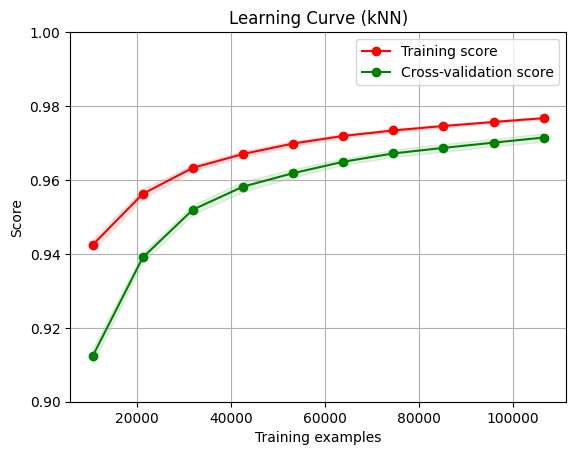

In [25]:
title = "Learning Curve (kNN)"
cv = ShuffleSplit(n_splits=10,          # number of re-shuffling & splitting iterations
                  test_size=0.2,        # represents the proportion of the dataset to include in the test split (float between 0.0 and 1.0) 
                  random_state=42)      # the seed used by the random number generator
estimator = KNeighborsClassifier()

plot_learning_curve(estimator,      # data science algorithm
                    title,          # title of the plot
                    X_oversampled_train, y_oversampled_train,           # data (features and target variable)
                    (0.9, 1),    # minimum and maximum y values plotted
                    cv=cv,          # cross-validation folds (produced above)
                    n_jobs=4)       # parallell estimation using multiple processors

plt.show() 

###4.9.3 Logistic Regression

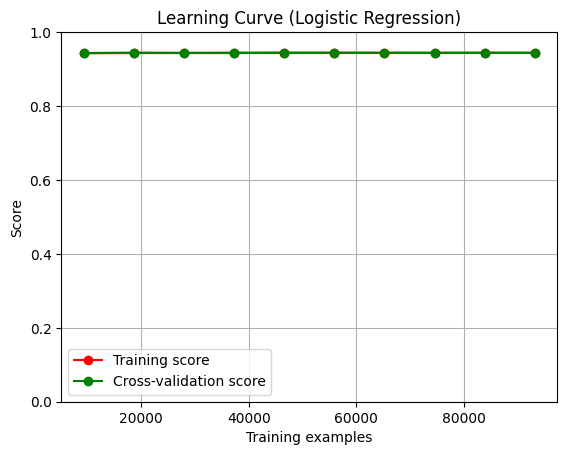

In [ ]:
title = "Learning Curve (Logistic Regression)"
cv = ShuffleSplit(n_splits=10,          # number of re-shuffling & splitting iterations
                  test_size=0.2,        # represents the proportion of the dataset to include in the test split (float between 0.0 and 1.0) 
                  random_state=42)      # the seed used by the random number generator
estimator = LogisticRegression()

plot_learning_curve(estimator,      # data science algorithm
                    title,          # title of the plot
                    X_oversampled_train, y_oversampled_train,           # data (features and target variable)
                    (0, 1),    # minimum and maximum y values plotted
                    cv=cv,          # cross-validation folds (produced above)
                    n_jobs=4)       # parallell estimation using multiple processors

plt.show() 

#5 Machine Learning with Nested Cross Validation (k=5)

In [26]:
inner_cv = KFold(n_splits=5, shuffle=True,random_state=42) # inner cross-validation folds
outer_cv = KFold(n_splits=5, shuffle=True,random_state=42)

##5.1 Decision Tree

In [27]:
#Decision TreeParameter Tuning
tree = DecisionTreeClassifier()
#define param options
param_grid_tree = {'max_depth': [1,2,3,4,5,6,7,8,None], 
                               'criterion':['gini','entropy'], 
                               'min_samples_leaf':[1,2,3,4,5],
                               'min_samples_split':[2,3,4,5]}
        

gs_tree = GridSearchCV(estimator=tree,
                  param_grid=param_grid_tree,
                  scoring="recall_macro",
                  cv=inner_cv,
                  n_jobs=4)

gs_tree = gs_tree.fit(X_oversampled_train, y_oversampled_train)  
print("Decision Tree Parameter Tuning")
print("Non-nested CV Recall: ", gs_tree.best_score_)
print("Optimal Parameter: ", gs_tree.best_params_)
print("Optimal Estimator: ", gs_tree.best_estimator_) # Estimator that was chosen by the search,
nested_score_gs_tree = cross_val_score(gs_tree, X=X_oversampled_train, y=y_oversampled_train, cv=outer_cv)
print("Nested CV Recall: ",nested_score_gs_tree.mean(), " +/- ", nested_score_gs_tree.std())

Decision Tree Parameter Tuning
Non-nested CV Recall:  0.9857973506911965
Optimal Parameter:  {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 3}
Optimal Estimator:  DecisionTreeClassifier(min_samples_split=3)
Nested CV Recall:  0.9858100001251074  +/-  0.00048295636061694997


##5.2 k-NN

In [28]:
#kNN Parameter Tuning
#Normalize Data
pipe = Pipeline([
        ('sc', StandardScaler()),     
        ('knn', KNeighborsClassifier(p=2, 
                                     metric='minkowski'))])

#define param options
param_grid_kNN = {
        'knn__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
        'knn__weights': ['uniform', 'distance']}

gs_knn = GridSearchCV(estimator=pipe,
                  param_grid=param_grid_kNN,
                  scoring="recall_macro",
                  cv=inner_cv,
                  n_jobs=4)

gs_knn = gs_knn.fit(X_oversampled_train, y_oversampled_train)  
print("kNN Parameter Tuning")
print("Non-nested CV recall: ", gs_knn.best_score_)
print("Optimal Parameter: ", gs_knn.best_params_)
print("Optimal Estimator: ", gs_knn.best_estimator_) # Estimator that was chosen by the search,
nested_score_gs_knn = cross_val_score(gs_knn, X=X_oversampled_train, y=y_oversampled_train, cv=outer_cv)
print("Nested CV recall: ",nested_score_gs_knn.mean(), " +/- ", nested_score_gs_knn.std())

kNN Parameter Tuning
Non-nested CV recall:  0.9736044611471574
Optimal Parameter:  {'knn__n_neighbors': 11, 'knn__weights': 'distance'}
Optimal Estimator:  Pipeline(steps=[('sc', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(n_neighbors=11, weights='distance'))])
Nested CV recall:  0.9735347462509724  +/-  0.0010042286759425038


##5.3 Logistic Regression

In [ ]:
#Logistic Regression Parameter Tuning
#To ignore the convergence warnings
from  warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

#define param options
param_grid_lr = {'C': [ 0.00001, 0.0001, 0.001, 0.01, 0.1 ,1 ,10 ,100, 1000, 10000, 100000, 1000000],
                   'penalty':['l1','l2']}

gs_lr = GridSearchCV(estimator=LogisticRegression(random_state=42, solver='liblinear'),
                  param_grid=param_grid_lr,
                  scoring="recall_macro",
                  cv=inner_cv)

gs_lr = gs_lr.fit(X_oversampled_train, y_oversampled_train)
print("Logistic Regression Parameter Tuning")
print("Non-nested CV recall: ", gs_lr.best_score_)
print("Optimal Parameter: ", gs_lr.best_params_)
print("Optimal Estimator: ", gs_lr.best_estimator_)
nested_score_gs_lr = cross_val_score(gs_lr, X=X_oversampled_train, y=y_oversampled_train,  cv=outer_cv)
print("Nested CV recall:",nested_score_gs_lr.mean(), " +/- ", nested_score_gs_lr.std())

Logistic Regression Parameter Tuning
Non-nested CV recall:  0.9492780144480136
Optimal Parameter:  {'C': 1, 'penalty': 'l2'}
Optimal Estimator:  LogisticRegression(C=1, random_state=42, solver='liblinear')
Nested CV recall: 0.9492780144480136  +/-  0.0007777656526430562


#6 Model Seleciton

##6.1 ROC graph

10-fold cross validation:

ROC AUC: 0.96 (+/- 0.00) [Logistic regression]
ROC AUC: 0.99 (+/- 0.00) [Decision tree]
ROC AUC: 0.99 (+/- 0.00) [kNN]


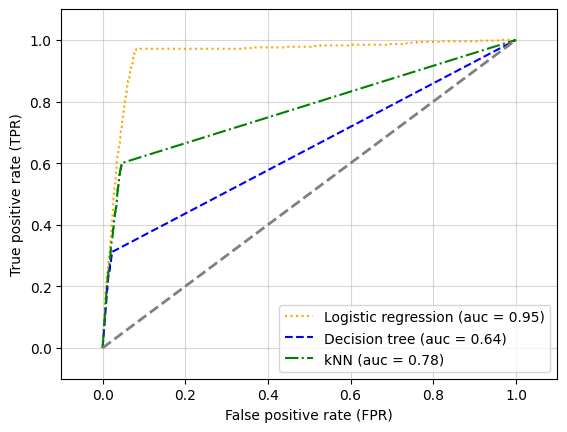

In [30]:
#X_train, X_test_ROC, y_train, y_test_ROC = train_test_split(X_new, y_new,test_size=0.2, random_state=42)
#ROC
# Logistic Regression Classifier
lr_best = LogisticRegression(penalty='l2', 
                          C=1,
                          random_state=42, 
                          solver='liblinear')

# Decision Tree Classifier
tree_best = DecisionTreeClassifier(max_depth=None,
                              criterion='gini',
                              min_samples_leaf=1,
                              min_samples_split=4,
                              random_state=42)


# kNN Classifier

knn_best = Pipeline([
        ('sc', StandardScaler()),     
        ('knn', KNeighborsClassifier(n_neighbors=11,
                                     weights='distance',
                                     p=2, 
                                     metric='minkowski')) ])

# Label the classifiers
clf_labels = ['Logistic regression', 'Decision tree', 'kNN']
all_clf = [lr_best, tree_best, knn_best]

#################################### Cross - Validation ####################################


print('10-fold cross validation:\n')
for clf, label in zip([lr_best, tree_best, knn_best], clf_labels): #For all classifiers 
    scores = cross_val_score(estimator=clf,  #C based on cross validation
                             X=X_oversampled_train,
                             y= y_oversampled_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" # print peformance statistics based on cross-validation
          % (scores.mean(), scores.std(), label))

##################################### Visualization ######################################

colors = [ 'orange', 'blue', 'green']      # colors for visualization
linestyles = [':', '--', '-.', '-']        # line styles for visualization
for clf, label, clr, ls in zip(all_clf,
               clf_labels, colors, linestyles):

    # Assuming the label of the positive class is 1 and data is normalized
    y_pred = clf.fit(X_oversampled_train, y_oversampled_train).predict_proba(X_test)[:, 1] # make predictions based on the classifiers
    
    fpr, tpr, thresholds = roc_curve(y_true=y_test,       # build ROC curve
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)                           # compute Area Under the Curve (AUC) 
    plt.plot(fpr, tpr,                                    # plot ROC Curve and create label with AUC values
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')    # where to place the legend
plt.plot([0, 1], [0, 1],         # visualize random classifier
         linestyle='--',         # aesthetic parameters
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])   #limits for x axis
plt.ylim([-0.1, 1.1])   #limits for y axis
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')


#plt.savefig('ROC_all_classifiers', dpi=300)
plt.show()

##6.2 Performance Metrics & Classification Report

###6.2.1 Decision Tree

In [ ]:
# Estimate the predicted values
dt_y_pred = tree_best.fit(X_oversampled_train,y_oversampled_train).predict(X_test) 
dt_y_pred_insample = tree_best.fit(X_oversampled_train,y_oversampled_train).predict(X_oversampled_train) 
print("Decision Tree Performance:")
# Accuracy
print('Accuracy (out-of-sample): %.2f' % accuracy_score(y_test, dt_y_pred))
print('Accuracy (in-sample): %.2f' % accuracy_score(y_oversampled_train, dt_y_pred_insample))

# F1 score
print('recall score (out-of-sample): ', recall_score(y_test, dt_y_pred, average='macro'))           # average='macro' calculate metrics for each label, and find their unweighted mean
print('recall score (in-sample)    : ', recall_score(y_oversampled_train, dt_y_pred_insample, average='macro')) # this macro value does not take label imbalance into account.

# Build a text report showing the main classification metrics (out-of-sample performance)
print(classification_report(y_test, dt_y_pred))             # builds a text report showing the main classification metrics (precision, recall, f1-score)

Decision Tree Performance:
Accuracy (out-of-sample): 0.96
Accuracy (in-sample): 0.99
recall score (out-of-sample):  0.6438664673169587
recall score (in-sample)    :  0.9914468813031379
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     19547
           1       0.22      0.31      0.26       453

    accuracy                           0.96     20000
   macro avg       0.60      0.64      0.62     20000
weighted avg       0.97      0.96      0.96     20000



###6.2.2 kNN

In [33]:
# Estimate the predicted values
from sklearn.metrics import recall_score


knn_y_pred = knn_best.fit(X_oversampled_train,y_oversampled_train).predict(X_test) 
knn_y_pred_insample = knn_best.fit(X_oversampled_train,y_oversampled_train).predict(X_oversampled_train) 
print("kNN Performance:")
# Accuracy
print('Accuracy (out-of-sample): %.2f' % accuracy_score(y_test, knn_y_pred))
print('Accuracy (in-sample): %.2f' % accuracy_score(y_oversampled_train, knn_y_pred_insample))

# F1 score
print('recall score (out-of-sample): ', recall_score(y_test, knn_y_pred, average='macro'))           # average='macro' calculate metrics for each label, and find their unweighted mean
print('recall score (in-sample)    : ', recall_score(y_oversampled_train, knn_y_pred_insample, average='macro')) # this macro value does not take label imbalance into account.

# Build a text report showing the main classification metrics (out-of-sample performance)
print(classification_report(y_test, knn_y_pred))             # builds a text report showing the main classification metrics (precision, recall, f1-score)

kNN Performance:
Accuracy (out-of-sample): 0.95
Accuracy (in-sample): 0.99
recall score (out-of-sample):  0.739886576656637
recall score (in-sample)    :  0.9855562447050148
              precision    recall  f1-score   support

           0       0.99      0.96      0.98     19547
           1       0.25      0.52      0.33       453

    accuracy                           0.95     20000
   macro avg       0.62      0.74      0.65     20000
weighted avg       0.97      0.95      0.96     20000



###6.2.3 Logistic Regression

In [34]:
# Estimate the predicted values
lr_y_pred = lr_best.fit(X_oversampled_train,y_oversampled_train).predict(X_test) 
lr_y_pred_insample = lr_best.fit(X_oversampled_train,y_oversampled_train).predict(X_oversampled_train) 
print("Logistics Regression Performance:")
# Accuracy
print('Accuracy (out-of-sample): %.2f' % accuracy_score(y_test, lr_y_pred))
print('Accuracy (in-sample): %.2f' % accuracy_score(y_oversampled_train, lr_y_pred_insample))

# F1 score
print('recall score (out-of-sample): ', recall_score(y_test, lr_y_pred, average='macro'))           # average='macro' calculate metrics for each label, and find their unweighted mean
print('recall score (in-sample)    : ', recall_score(y_oversampled_train, lr_y_pred_insample, average='macro')) # this macro value does not take label imbalance into account.

# Build a text report showing the main classification metrics (out-of-sample performance)
print(classification_report(y_test, lr_y_pred))             # builds a text report showing the main classification metrics (precision, recall, f1-score)

Logistics Regression Performance:
Accuracy (out-of-sample): 0.92
Accuracy (in-sample): 0.94
recall score (out-of-sample):  0.9439747363884704
recall score (in-sample)    :  0.9492847679268029
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     19547
           1       0.22      0.97      0.36       453

    accuracy                           0.92     20000
   macro avg       0.61      0.94      0.66     20000
weighted avg       0.98      0.92      0.94     20000



##6.3 Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix           # confusion_matrix will help us compute confusion matrix
import itertools
import matplotlib.pyplot as plt

In [ ]:
# Function that prints and plots the confusion matrix.
# Normalization can be applied by setting `normalize=True` (see below for examples)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # devide absolute number of observations with sum across columns to get the relative percentage of observations
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)         # shows the confusion matrix in the console
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))                       # add tick marks to the confusion matrix
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'                          # choose format depending on whether the confusion matrix is normalizaed or not
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])): # loop that adds the value to each cell of the confusion matrix
        plt.text(j, i, format(cm[i, j], fmt),                              # we reformat how the cell values are displayed accroding to the variable fmt we defined before
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

###6.3.1 Decision tree

Confusion matrix, without normalization
[[19044   503]
 [  311   142]]


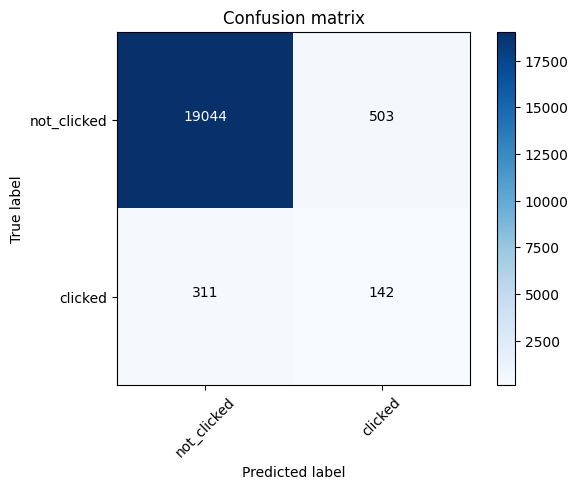

In [ ]:
tree_y_pred =tree_best.fit(X_oversampled_train,y_oversampled_train).predict(X_test) 
np.set_printoptions(precision=2)                                                                              
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, tree_y_pred), classes= ['not_clicked', 'clicked'], title='Confusion matrix')    
plt.show()

###6.3.2 kNN

Confusion matrix, without normalization
[[18828   719]
 [  219   234]]


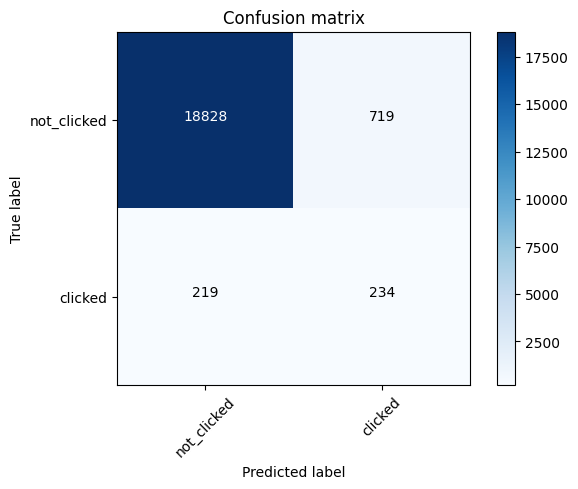

In [ ]:
knn_y_pred =knn_best.fit(X_oversampled_train,y_oversampled_train).predict(X_test) 
np.set_printoptions(precision=2)                                                                              
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, knn_y_pred), classes= ['not_clicked', 'clicked'], title='Confusion matrix')    
plt.show()

###6.3.3 Logistic Regression

Confusion matrix, without normalization
[[18004  1543]
 [   15   438]]


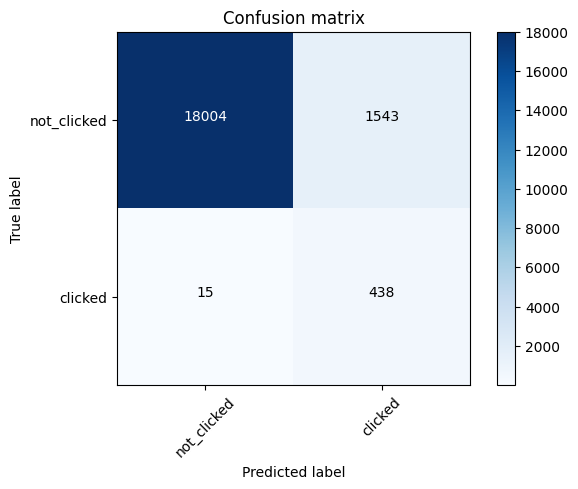

In [ ]:
lr_y_pred =lr_best.fit(X_oversampled_train,y_oversampled_train).predict(X_test) 
np.set_printoptions(precision=2)                                                                              
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, lr_y_pred), classes= ['not_clicked', 'clicked'], title='Confusion matrix')    
plt.show()

##6.4 Learning Curve

In [ ]:
#learning curve for logistic regression
def plot_learning_curve(estimator,        # data science algorithm
                        title,            # title of the plot
                        X_oversampled_train, y_oversampled_train,             # data (features and target variable)
                        ylim=None,        # minimum and maximum y values plotted
                        cv=None,          # cross validation splits
                        n_jobs=1,         # parallell estimation using multiple processors
                        train_sizes=np.linspace(.1, 1.0, 10)): #linspace returns evenly spaced numbers over a specified interval (start, stop, num)
        plt.figure()                    # display figure
        plt.title(title)                # specify title based on parameter provided as input
        if ylim is not None:            # if ylim was specified as an input, make sure the plots use these limits
            plt.ylim(*ylim)
        plt.xlabel("Training examples") # y label title
        plt.ylabel("Score")
        
        train_sizes, train_scores, test_scores = learning_curve(estimator, # data science algorithm
                                                            X_oversampled_train, y_oversampled_train,      # data (features and target variable)  
                                                            cv=cv,     # cross-validation folds
                                                            n_jobs=n_jobs, # number of jobs to run in parallel using multiple processors
                                                            train_sizes=train_sizes) 
        
        train_scores_mean = np.mean(train_scores, axis=1) # compute the arithmetic mean along the specified axis.
        train_scores_std = np.std(train_scores, axis=1)   # compute the standard deviation along the specified axis.
        test_scores_mean = np.mean(test_scores, axis=1)   # compute the arithmetic mean along the specified axis.
        test_scores_std = np.std(test_scores, axis=1)     # compute the standard deviation along the specified axis.

        plt.grid()
        
        plt.fill_between(train_sizes,                            # the x coordinates of the nodes defining the curves
                     train_scores_mean - train_scores_std,   # the y coordinates of the nodes defining the first curve
                     train_scores_mean + train_scores_std,   # the y coordinates of the nodes defining the second curve
                     alpha=0.1,                              # level of transparency in the color fill
                     color="r")                              # train data performance indicated with red
        plt.fill_between(train_sizes, 
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, 
                     alpha=0.1,
                     color="g")  
        
        # Cross-validation means indicated by dots
        # Train data performance indicated with red
        plt.plot(train_sizes,                                    # the horizontal coordinates of the data points 
                 train_scores_mean,                              # the vertical coordinates of the data points
                 'o-',                                           # o- will produce a small circle and a solid line to connect the markers
                 color="r",                                      # line of red color
                 label="Training score") 
        
        # Test data performance indicated with green
        plt.plot(train_sizes, 
                 test_scores_mean, 
                 'o-', 
                 color="g",                                      # line of green color
                 label="Cross-validation score")
        
        plt.legend(loc="best")                      # show legend of the plot at the best location possible
        return plt

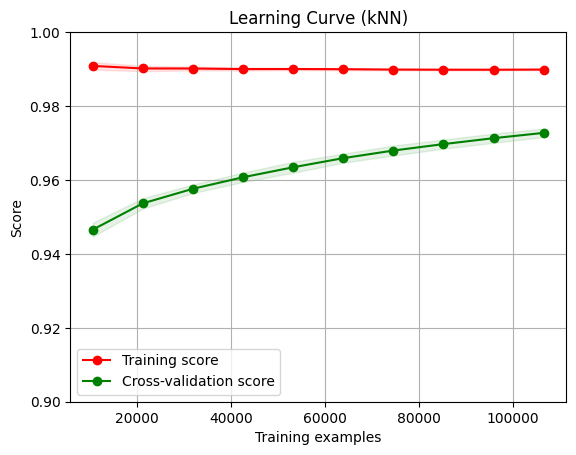

In [ ]:
title = "Learning Curve (kNN)"
cv = ShuffleSplit(n_splits=10,          # number of re-shuffling & splitting iterations
                  test_size=0.2,        # represents the proportion of the dataset to include in the test split (float between 0.0 and 1.0) 
                  random_state=42)      # the seed used by the random number generator
estimator = knn_best

plot_learning_curve(estimator,      # data science algorithm
                    title,          # title of the plot
                    X_oversampled_train, y_oversampled_train,           # data (features and target variable)
                    (0.9, 1),    # minimum and maximum y values plotted
                    cv=cv,          # cross-validation folds (produced above)
                    n_jobs=4)       # parallell estimation using multiple processors

plt.show() 

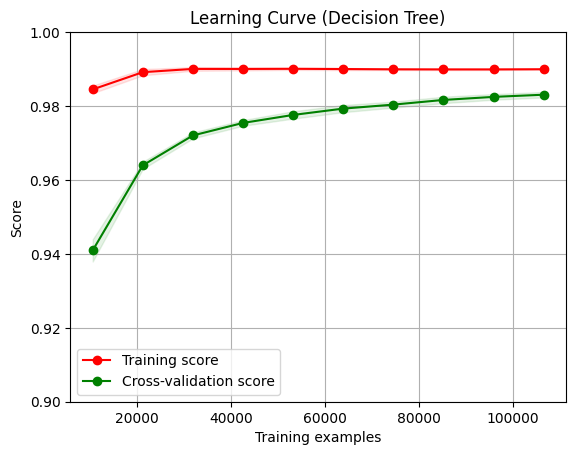

In [ ]:
title = "Learning Curve (Decision Tree)"
cv = ShuffleSplit(n_splits=10,          # number of re-shuffling & splitting iterations
                  test_size=0.2,        # represents the proportion of the dataset to include in the test split (float between 0.0 and 1.0) 
                  random_state=42)      # the seed used by the random number generator
estimator = tree_best

plot_learning_curve(estimator,      # data science algorithm
                    title,          # title of the plot
                    X_oversampled_train, y_oversampled_train,           # data (features and target variable)
                    (0.9, 1),    # minimum and maximum y values plotted
                    cv=cv,          # cross-validation folds (produced above)
                    n_jobs=4)       # parallell estimation using multiple processors

plt.show() 

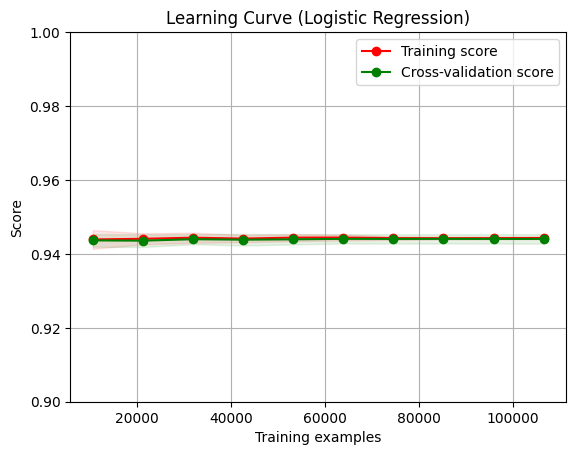

In [ ]:
title = "Learning Curve (Logistic Regression)"
cv = ShuffleSplit(n_splits=10,          # number of re-shuffling & splitting iterations
                  test_size=0.2,        # represents the proportion of the dataset to include in the test split (float between 0.0 and 1.0) 
                  random_state=42)      # the seed used by the random number generator
estimator = lr_best

plot_learning_curve(estimator,      # data science algorithm
                    title,          # title of the plot
                    X_oversampled_train, y_oversampled_train,           # data (features and target variable)
                    (0.9, 1),    # minimum and maximum y values plotted
                    cv=cv,          # cross-validation folds (produced above)
                    n_jobs=4)       # parallell estimation using multiple processors

plt.show() 

##6.5 Profit Curve

In [35]:
import numpy as np


In [36]:
#Cost assumptions
'''Cost of FP: 1, cost of FN: 2, cost of TN: 0, cost of TP: -1'''
cost_TP = -99; cost_FP = 1; cost_FN = 0; cost_TN = 0;
cb_matrix = -1*np.array([[cost_TN, cost_FN],[cost_FP, cost_TP]])
#X_train, X_test, y_train, y_test = train_test_split(X_oversampled_train, y_oversampled_train.values)
cb_matrix

array([[ 0,  0],
       [-1, 99]])

In [37]:
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
def profit_curve(cb, predict_probas, labels):
    #predict_probas = round(predict_probas,4)
    indices = np.argsort(predict_probas)
    sorted_probs = predict_probas[indices]
    sorted_labels = labels[indices]
    
    profit_list = []
    
    for sp, sl in zip(sorted_probs, sorted_labels):
        predict_labels = sorted_probs > sp + .0001
        conf_mat = confusion_matrix(sorted_labels, predict_labels)
        profit_list.append((cb * conf_mat).sum() / float(len(labels)))
    return profit_list, sorted_probs


In [38]:
# Plot the profit curves
def plot_profit_curve(model, label, costbenefit, X_train, X_test, y_train, y_test, col):
    model.fit(X_train, y_train)
    predict_probas = model.predict_proba(X_test)[:,1]
    profit_list, sorted_probs = profit_curve(costbenefit, predict_probas, y_test)
    max_index = np.argmax(profit_list)
    max_threshold = sorted_probs[max_index]
    max_profit = profit_list[max_index]
    
    plt.plot(sorted_probs, profit_list, label=label, color=col, linewidth=3)
    plt.plot(max_threshold, max_profit, '.', color=col, markersize=18)


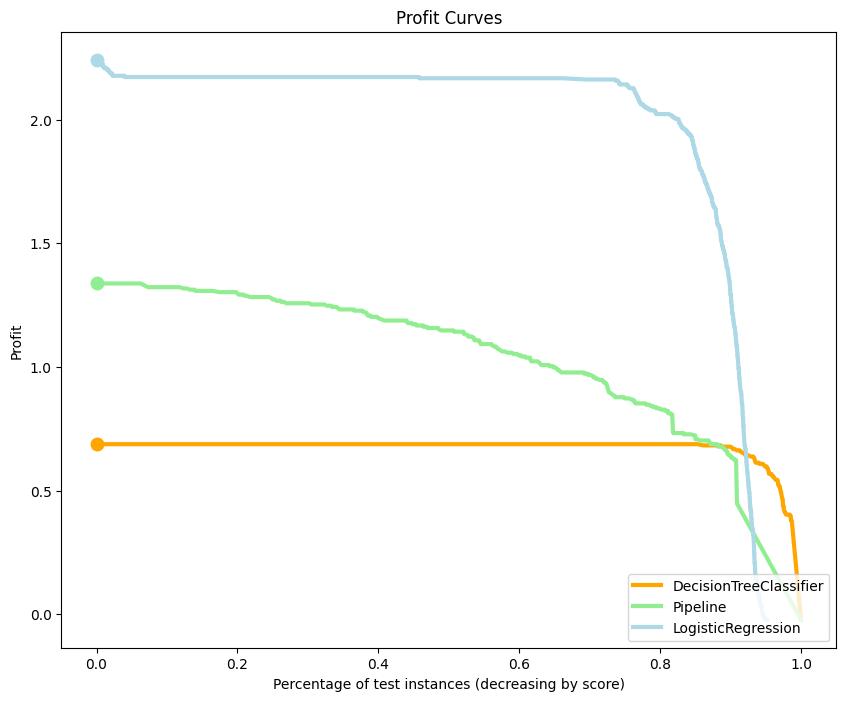

In [39]:
# Plot the profit curves and mark the optimum point for each model
models = [tree_best, knn_best, lr_best]
fig = plt.figure(figsize=(10,8))
# fig.set_facecolor('#F2F2F2')
colors = ['orange', 'lightgreen', 'lightblue']
for i, model in enumerate(models):
    plot_profit_curve(model, model.__class__.__name__, cb_matrix,
                      X_oversampled_train, X_test, y_oversampled_train.values, y_test.values, colors[i])
plt.title("Profit Curves")
plt.xlabel("Percentage of test instances (decreasing by score)")
plt.ylabel("Profit")
plt.legend(loc='lower right')
plt.savefig('Profit_curve.png', facecolor=fig.get_facecolor())
plt.show()
